In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.python.client import device_lib
import time
import csv
import re
import os
import matplotlib.pyplot as plt
import pylab
import json

In [5]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
HIDDEN_SIZE = 20
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01
use_dropout = True

seed = 10
tf.random.set_seed(seed)

In [6]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpus)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        devices = device_lib.list_local_devices()
        avail_gpu = [x for x in devices if x.device_type == 'GPU']
        print('\n',avail_gpu)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No gpus available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs

 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3048682292
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16509641564636592794
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [7]:
# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

In [8]:
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

In [9]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./data/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./data/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

In [10]:
def load_history(model_name, dropout):
    if dropout:
        with open(f'./histories/{model_name}_dropout') as file:
            history = json.load(file)
    else:
        with open(f'./histories/{model_name}_nodropout') as file:
            history = json.load(file)
    return history

In [11]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [12]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [13]:
class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, 256)
        x = self.rnn(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)

        return logits

In [14]:
# Build model
tf.keras.backend.set_floatx('float32')
model = CharRNN(vocab_size=256, hidden_dim=HIDDEN_SIZE)

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [15]:
name = 'CharRNN'

test_acc = []
train_acc = []
test_l = []
train_l = []

start_time = time.time()

drop_rate = 0.5 if use_dropout else 0
print(drop_rate)

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate)  # drop_rate=0 iff not DO_Q5 change to 0.5 for Q5

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate)   # drop_rate=0 iff not DO_Q5 change to 0.5 for Q5

    test_acc.append(test_accuracy.result().numpy().astype(float))
    train_acc.append(train_accuracy.result().numpy().astype(float))
    test_l.append(test_loss.result().numpy().astype(float))
    train_l.append(train_loss.result().numpy().astype(float))

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result())
    print(template)

time_taken = time.time() - start_time

0.5
Epoch 1, Loss: 2.6670546531677246, Accuracy: 0.08303571492433548, Test Loss: 2.624258041381836, Test Accuracy: 0.09428571164608002
Epoch 2, Loss: 2.609372138977051, Accuracy: 0.10321428626775742, Test Loss: 2.595599889755249, Test Accuracy: 0.08285713940858841
Epoch 3, Loss: 2.4866859912872314, Accuracy: 0.14017857611179352, Test Loss: 2.3897762298583984, Test Accuracy: 0.16571427881717682
Epoch 4, Loss: 2.2642247676849365, Accuracy: 0.1882142871618271, Test Loss: 2.1835241317749023, Test Accuracy: 0.23999999463558197
Epoch 5, Loss: 2.063290596008301, Accuracy: 0.26053571701049805, Test Loss: 2.021404981613159, Test Accuracy: 0.3142857253551483
Epoch 6, Loss: 1.8633002042770386, Accuracy: 0.33517858386039734, Test Loss: 1.8969749212265015, Test Accuracy: 0.3328571319580078
Epoch 7, Loss: 1.7163963317871094, Accuracy: 0.38624998927116394, Test Loss: 1.7621830701828003, Test Accuracy: 0.38428571820259094
Epoch 8, Loss: 1.5977845191955566, Accuracy: 0.42875000834465027, Test Loss: 1.7

Epoch 64, Loss: 0.7804626226425171, Accuracy: 0.7337499856948853, Test Loss: 1.187413215637207, Test Accuracy: 0.6671428680419922
Epoch 65, Loss: 0.7827029824256897, Accuracy: 0.7455357313156128, Test Loss: 1.230538249015808, Test Accuracy: 0.6714285612106323
Epoch 66, Loss: 0.7547433376312256, Accuracy: 0.7380357384681702, Test Loss: 1.2118481397628784, Test Accuracy: 0.6600000262260437
Epoch 67, Loss: 0.7442872524261475, Accuracy: 0.7516071200370789, Test Loss: 1.2075258493423462, Test Accuracy: 0.6600000262260437
Epoch 68, Loss: 0.7376847863197327, Accuracy: 0.7549999952316284, Test Loss: 1.2305450439453125, Test Accuracy: 0.6499999761581421
Epoch 69, Loss: 0.7825504541397095, Accuracy: 0.7341071367263794, Test Loss: 1.1678942441940308, Test Accuracy: 0.6499999761581421
Epoch 70, Loss: 0.7556216716766357, Accuracy: 0.7439285516738892, Test Loss: 1.3144150972366333, Test Accuracy: 0.6614285707473755
Epoch 71, Loss: 0.7918161749839783, Accuracy: 0.7317857146263123, Test Loss: 1.266521

Epoch 127, Loss: 0.6303057670593262, Accuracy: 0.793571412563324, Test Loss: 1.2919918298721313, Test Accuracy: 0.6600000262260437
Epoch 128, Loss: 0.6453720927238464, Accuracy: 0.7803571224212646, Test Loss: 1.3583083152770996, Test Accuracy: 0.6385714411735535
Epoch 129, Loss: 0.7028268575668335, Accuracy: 0.7632142901420593, Test Loss: 1.3070682287216187, Test Accuracy: 0.6428571343421936
Epoch 130, Loss: 0.6882226467132568, Accuracy: 0.7691071629524231, Test Loss: 1.3562110662460327, Test Accuracy: 0.645714282989502
Epoch 131, Loss: 0.7014272809028625, Accuracy: 0.7685714364051819, Test Loss: 1.3477319478988647, Test Accuracy: 0.6657142639160156
Epoch 132, Loss: 0.6802290081977844, Accuracy: 0.7744643092155457, Test Loss: 1.3134074211120605, Test Accuracy: 0.6557142734527588
Epoch 133, Loss: 0.6914289593696594, Accuracy: 0.7678571343421936, Test Loss: 1.280457854270935, Test Accuracy: 0.6628571152687073
Epoch 134, Loss: 1.250349998474121, Accuracy: 0.6832143068313599, Test Loss: 2.

Epoch 190, Loss: 0.6712401509284973, Accuracy: 0.7703571319580078, Test Loss: 1.2983051538467407, Test Accuracy: 0.6742857098579407
Epoch 191, Loss: 0.6698909401893616, Accuracy: 0.7778571248054504, Test Loss: 1.3100147247314453, Test Accuracy: 0.6671428680419922
Epoch 192, Loss: 0.6398934125900269, Accuracy: 0.783214271068573, Test Loss: 1.2503536939620972, Test Accuracy: 0.6328571438789368
Epoch 193, Loss: 0.6673935055732727, Accuracy: 0.7764285802841187, Test Loss: 1.2375351190567017, Test Accuracy: 0.6628571152687073
Epoch 194, Loss: 0.6214542984962463, Accuracy: 0.7867857217788696, Test Loss: 1.3282021284103394, Test Accuracy: 0.6671428680419922
Epoch 195, Loss: 0.6073078513145447, Accuracy: 0.7942857146263123, Test Loss: 1.3127548694610596, Test Accuracy: 0.6671428680419922
Epoch 196, Loss: 0.6165521144866943, Accuracy: 0.7882142663002014, Test Loss: 1.257300853729248, Test Accuracy: 0.6671428680419922
Epoch 197, Loss: 0.642101526260376, Accuracy: 0.7869642972946167, Test Loss: 1

In [16]:
print(time_taken)

2643.062230348587


In [17]:
history = {name: {
    'accuracy': train_acc,
    'val_acc': test_acc,
    'loss': train_l,
    'val_loss': test_l,
    'time_taken': time_taken
}}

if use_dropout:
    with open(f'./histories/{name}_dropout', 'w') as file:
        json.dump(history, file)
else:
    with open(f'./histories/{name}_nodropout', 'w') as file:
        json.dump(history, file)

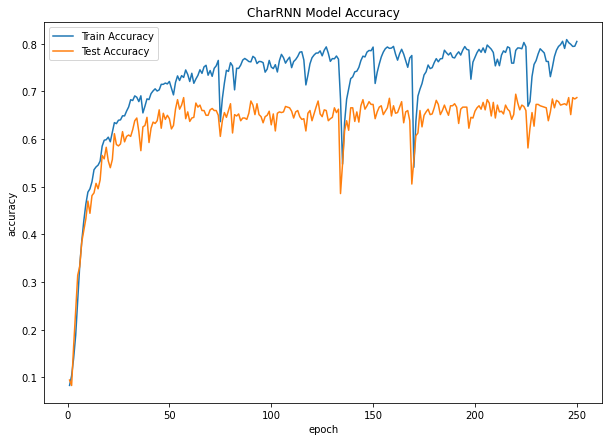

In [19]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['accuracy'], label='Train Accuracy')
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['val_acc'], label='Test Accuracy')
plt.title(f'{name} Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
if use_dropout:
    plt.savefig(
            f'./results/QuestionB3_{name}_accuracy_dropout.pdf'
        )
else:
    plt.savefig(
            f'./results/QuestionB3_{name}_accuracy_nodropout.pdf'
        )

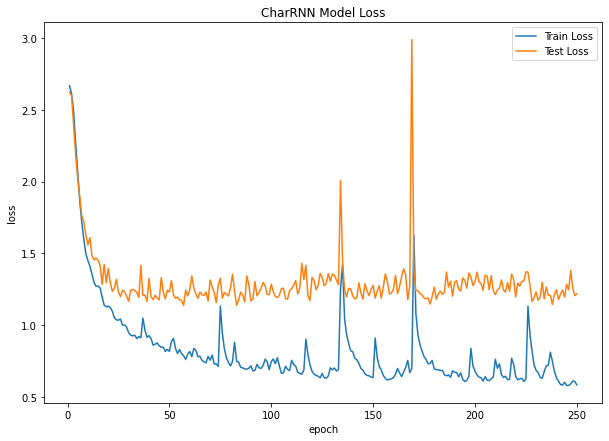

In [20]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['loss'], label='Train Loss')
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['val_loss'], label='Test Loss')
plt.title(f'{name} Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
if use_dropout:
    plt.savefig(
            f'./results/QuestionB3_{name}_loss_dropout.pdf'
        )
else:
    plt.savefig(
            f'./results/QuestionB3_{name}_loss_nodropout.pdf'
        )